# Oxytocin analysis code

In [1]:
import utility_functions # loading and processing code

# matplotlib stuff
import ipympl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon # errorbars and standard deviations
# %matplotlib ipympl

# # data analysis standards
import numpy as np
# import pandas as pd
# from scipy import signal
import os, re
from pathlib import Path

# # csv writing for figure data etc
# import csv
# import xmltodict

# Data import and cleaning

Bring in the data, do some basic cleaning before sending it to Kilosort etc

In [57]:
# recording directory
# assume all subdirectories are from the same session and to be concatenated
# recording_dir = 'Y:/Sara/in vivo phys/open_ephys/Mudd data/oxt-cre_f2501_2025-02-21_12-52-33'
recording_dir = "Y:/Sara/in vivo phys/open_ephys/Mudd data/test locomotion/test_2025-05-14_17-48-41"
probe_map = "Y:/Sara/in vivo phys/64-4shank-tet-chanMap.mat"

# rec = utility_functions.open_raw(recording_dir)
rec = utility_functions.recording(directory=recording_dir, probe_map=probe_map)



In [58]:
rec.open_raw()

In [ ]:
# magnitude of rotation
mag = np.cumsum()

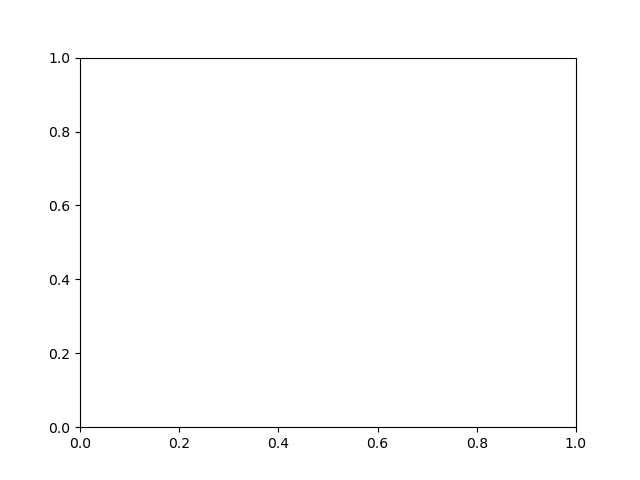

In [81]:
fig,ax = plt.subplots()

# ax.plot(np.cumsum(rec.raw_events['state'][rec.raw_events['channel'].eq(3)])/720)# - np.cumsum(rec.raw_events['state'][rec.raw_events['channel'].eq(4)]))
# ax.plot(np.cumsum(rec.raw_events['state'][rec.raw_events['channel'].eq(4)]))

aa = rec.raw_events['state'][rec.raw_events['channel'].eq(3)] - rec.raw_events['state'][rec.raw_events['channel'].eq(4)]


7200    NaN
7202    NaN
7204    NaN
7205    NaN
7207    NaN
         ..
15853   NaN
15855   NaN
15856   NaN
15857   NaN
15858   NaN
Name: state, Length: 4336, dtype: float64

In [64]:
rec.raw_events

,channel,timestamp,processor_id,subprocessor_id,state
0,1,870728,100,0,1
1,1,870758,100,0,0
2,1,870760,100,0,1
3,1,870790,100,0,0
4,1,870791,100,0,1
...,...,...,...,...,...
15854,5,3188036,100,0,0
15855,3,3190339,100,0,0
15856,3,3201785,100,0,1
15857,3,3215532,100,0,0


In [56]:
if not all([np.sum(rec.raw_events['channel'].eq(chan)) for chan in [1,2]]):
    print('asdf')

asdf


In [ ]:
np.where(rec.raw_events['channel'])

(array([], dtype=int64),)

In [7]:
channel_mask = np.sqrt((rec.probe_map['xc'][:,None] - rec.probe_map['xc'])**2 
                       + (rec.probe_map['yc'][:,None] - rec.probe_map['yc'])**2) # 
channel_mask = (channel_mask < 100) # only keep locations more than 100 um apart

In [12]:
from scipy import signal
from sklearn.decomposition import PCA
from time import time
from tqdm._tqdm_notebook import tqdm

In [22]:
sos_filt = signal.butter(N=2, Wn=[10], fs = 30000, output = 'sos', btype='high')
filt_sig = signal.sosfiltfilt(sos_filt, rec.raw_sig[:100000,:], axis=0)
eraasr_lstsq = np.empty_like(filt_sig)
eraasr_normal = np.empty_like(filt_sig)

pca = PCA(n_components=4)
pca.fit(filt_sig)

for channel in tqdm(np.arange(filt_sig.shape[1])):
    Wnc = pca.components_.copy() # KxN
    Wnc[:,channel] = 0

    Ac = np.matmul(filt_sig,Wnc.T) # TxK
    t_start = time()
    ArtMat = np.linalg.lstsq(Ac,filt_sig[:,channel], rcond=None)[0] # Kx1
    eraasr_lstsq[:,channel] = filt_sig[:,channel] - np.matmul(Ac,ArtMat) # Kx1 - Kx1
    t_elapsed = time() - t_start
    print(f'Least Squares: {t_elapsed}')


    t_start = time()
    eraasr_normal[:,channel] = filt_sig[:,channel] - np.matmul(Ac, np.matmul(np.linalg.pinv(Ac), filt_sig[:,channel])) # Kx1 - KxN * (NxK * Kx1)
    t_elapsed = time() - t_start
    print(f'normal equation: {t_elapsed}')

  0%|          | 0/64 [00:00<?, ?it/s]

Least Squares: 0.0156402587890625
normal equation: 0.015605449676513672
Least Squares: 0.0156252384185791
normal equation: 0.0
Least Squares: 0.0
normal equation: 0.015733718872070312
Least Squares: 0.015547752380371094
normal equation: 0.015633583068847656
Least Squares: 0.0
normal equation: 0.027271270751953125
Least Squares: 0.0
normal equation: 0.01562976837158203
Least Squares: 0.0
normal equation: 0.015565156936645508
Least Squares: 0.0
normal equation: 0.015085935592651367
Least Squares: 0.0
normal equation: 0.01569676399230957
Least Squares: 0.0
normal equation: 0.01561737060546875
Least Squares: 0.0
normal equation: 0.015724897384643555
Least Squares: 0.0
normal equation: 0.015624523162841797
Least Squares: 0.0
normal equation: 0.01562666893005371
Least Squares: 0.0
normal equation: 0.01562643051147461
Least Squares: 0.01563286781311035
normal equation: 0.0
Least Squares: 0.0
normal equation: 0.015739917755126953
Least Squares: 0.0156252384185791
normal equation: 0.0
Least Squ

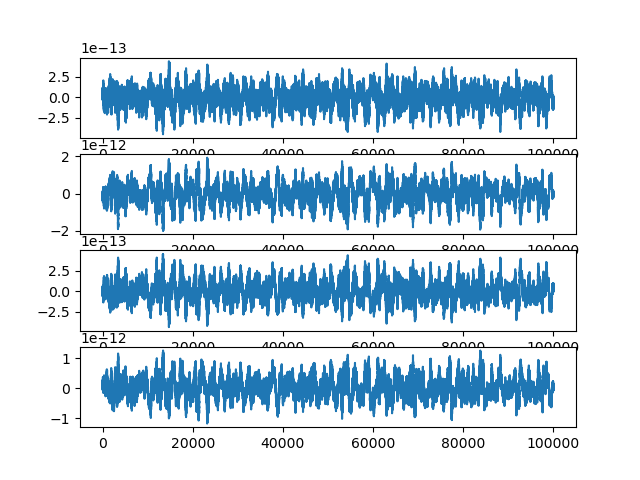

In [24]:
%matplotlib ipympl
channels = [10, 20, 30, 40]

fig,ax = plt.subplots(nrows=len(channels))

for i_channel, channel in enumerate(channels):
    # ax[i_channel].plot(eraasr_lstsq[:,channel], label='least squares')
    # ax[i_channel].plot(eraasr_normal[:,channel], label='normal equation')
    ax[i_channel].plot(eraasr_normal[:,channel] - eraasr_lstsq[:,channel])

    # ax[i_channel].legend()

In [32]:
if 'eraasr_cleaned' not in dir(rec):
    print('yes')

yes


In [28]:
eraasr_normal.mean(axis=0)

array([ 4.76064444e-03,  7.53292160e-03, -1.51810694e-02, -4.08849029e-04,
       -2.27756806e-02, -3.64939744e-03,  1.79396589e-03,  1.10788337e-02,
       -9.24943696e-03,  9.36663263e-04,  4.10714764e-02, -5.09152664e-03,
       -1.09394415e-02,  1.03303003e-02, -9.25979400e-04, -1.29897506e-02,
       -1.07317612e-02,  6.74030097e-03,  1.29598810e-03, -3.32152663e-03,
       -9.64811568e-03,  1.23650624e-02,  3.80274032e-03,  1.03547553e-03,
        4.64962544e-03, -7.76416078e-03,  1.18179693e-02, -3.40780318e-03,
        1.58553879e-02,  1.19612796e-02, -3.61505343e-04, -8.45449069e-03,
        1.19891141e-02, -2.37371052e-02,  5.94081576e-03, -1.98907185e-02,
       -5.38586737e-02,  2.45727241e-02, -2.80756883e-03, -2.34263650e-02,
        4.77318587e-02,  5.78224050e-03,  6.62120156e-04,  1.19949227e-02,
       -5.53937647e-03, -2.26769432e-03,  9.93495680e-04,  2.41526175e-02,
       -3.85646221e-02,  4.66069741e-03, -1.98414628e-02, -1.68231556e-03,
       -1.13494075e-02,  

In [4]:
rec.ERAASR()

[ERAASR] not enough space in memory, creating memmap for array


[ERAASR] cleaning:   0%|          | 0/4 [05:18<?, ?it/s]


LinAlgError: 1-dimensional array given. Array must be two-dimensional

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=4)
pca.fit(rec.raw_sig[:10000,:])

In [ ]:
Wnc = pca.components_.copy()
Wnc[:,10] = 0

Ac = np.matmul(rec.raw_sig[:10000,:],Wnc.T)

In [ ]:
Ac.shape

In [ ]:
ArtMat = np.linalg.lstsq(Ac,rec.raw_sig[:10000,10], rcond=None)

In [ ]:
ArtMat[0].shape

In [ ]:
%matplotlib ipympl

fig,ax = plt.subplots(nrows=2, sharex=True)
# ax.plot(np.matmul(rec.raw_sig[:10000,:],pca.components_.T))
ax[0].plot(rec.raw_sig[:10000,10])
ax[0].plot(np.matmul(Ac,ArtMat[0]))

ax[1].plot(rec.raw_sig[:10000,10] - np.matmul(Ac,ArtMat[0]))

In [ ]:
np.unique(np.sqrt((rec.probe_map['xc'][:,None] - rec.probe_map['xc'])**2 + (rec.probe_map['yc'][:,None] - rec.probe_map['yc'])**2))


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
time_window = 30000*60*5

sos = signal.butter(N=2, Wn=10, fs=30000, btype='highpass', output='sos')
filt_sig = signal.sosfiltfilt(sos, sig[:time_window,:], axis=0)

pca = PCA(n_components=1)
pca.fit(filt_sig)

In [ ]:
# across-channel artifacts
sig_clean = np.empty_like(filt_sig) # make a copy for subtraction
for channel in np.arange(sig.shape[1]):
    Wnc = pca.components_.copy() # make a copy for the exclusionary projection matrix
    Wcc = Wnc[:,channel].copy() # and the channel-specific reprojection
    Wnc[:,channel] = 0 # exclude channel's contribution
    Ac = np.matmul(filt_sig, Wnc.T)
    ArtMat = np.linalg.lstsq(Ac,filt_sig[:,channel], rcond=None)[0]
    sig_clean[:,channel] = filt_sig[:,channel] - np.matmul(Ac,ArtMat)

In [ ]:
from matplotlib import pyplot as plt
import ipympl
# %matplotlib ipympl

channels = [10,20,30,40]
fig,ax = plt.subplots(nrows=2, sharex=True)

ax[0].plot(timestamps[:time_window],sig[:time_window,channels])
ax[1].plot(timestamps[:time_window],sig_clean[:,channels])

# ax[0].set_xticks([0])
ax[1].set_xlabel('Time (s)')
ax[0].set_ylabel('Voltage (uV)')
ax[1].set_ylabel('Voltage (uV)')

In [ ]:
for ax_ in ax:
    for spine in ax_.spines:
        ax_.spines[spine].set_visible(False)

In [ ]:
ax[0].set_title('Raw Recording')
ax[1].set_title('Cleaned Recording')

In [ ]:
os.listdir('Y:')

In [ ]:
# dir(session.recordnodes[0].recordings[0])
# dir(session)
# dir(session.recordnodes[0].recordings[0].continuous[0])
session.recordnodes[0].recordings[0].continuous[0].metadata

In [ ]:
# from glob import glob


settings_file = glob(f'{recording_dir}{path.sep}**{path.sep}*settings.xml',recursive=True)

if len(settings_file)!=1:
    print('Cannot find a single settings file')


with open(settings_file[0],'r', encoding='utf8') as fid:
#     # settings = fid.readlines()
    settings = xmltodict.parse(fid.read())['SETTINGS']
# settings = xmltodict.parse(settings_file[0])

In [ ]:
# from sklearn.decomposition import PCA

utility_functions.ERAASR(sig[0])
# sig